In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
def permutation_test(df, group_col='감독', cluster_col='cluster_kmeans', n_permutations=10000, seed=42):
    np.random.seed(seed)

    # 1. 실제 chi² 통계량
    observed_ct = pd.crosstab(df[group_col], df[cluster_col])
    observed_chi2, _, _, _ = chi2_contingency(observed_ct)

    # 2. 순열 chi² 통계량들
    chi2_distribution = []

    for _ in range(n_permutations):
        shuffled = df[group_col].sample(frac=1, replace=False).reset_index(drop=True)
        shuffled_df = df.copy()
        shuffled_df[group_col] = shuffled

        ct = pd.crosstab(shuffled_df[group_col], shuffled_df[cluster_col])

        # ➕ 교차표가 너무 희소하면 패스
        if ct.shape[0] > 1 and ct.shape[1] > 1:
            try:
                chi2, _, _, _ = chi2_contingency(ct)
                chi2_distribution.append(chi2)
            except:
                continue

    # 3. chi2 분포가 비어 있는 경우 방어 처리
    if len(chi2_distribution) == 0:
        return observed_chi2, np.nan, []

    # 4. p-value 계산
    p_perm = np.mean(np.array(chi2_distribution) >= observed_chi2)
    return observed_chi2, p_perm, chi2_distribution


✅ 최적 피처 수: 17
선택된 피처: ['점유율', '패스성공률(%)', '패스 성공', '키패스', '공격진영 패스', '중앙지역 패스', '수비진영 패스', '롱패스', '중거리패스', '단거리패스', '전방패스', '횡패스', '후방패스', '크로스', '패스', '공격진영 패스 비율', '단거리패스 비율']


/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_28526/340092517.py:60: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_28526/340092517.py:60: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_28526/340092517.py:60: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_28526/340092517.py:60: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_28526/340092517.py:60: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packa

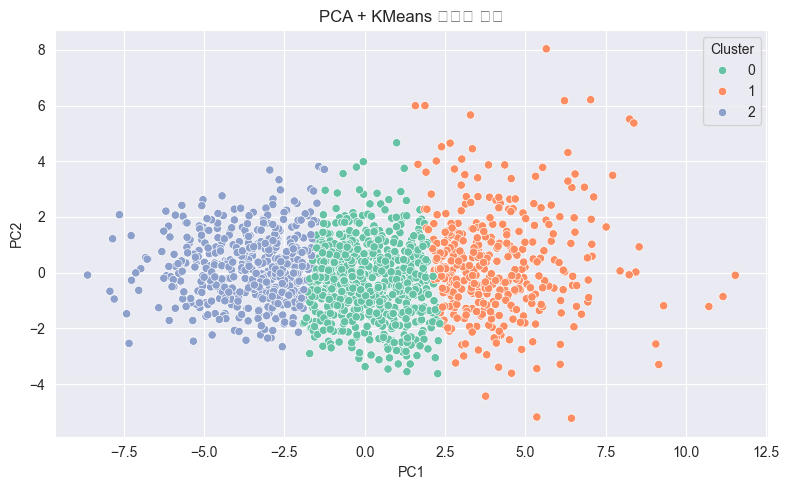

In [71]:
data = pd.read_csv('dataset.csv')
df = pd.DataFrame(data)

min_games = 38

# 감독별 경기 수 집계
manager_counts = df['감독'].value_counts()

# 유지 대상 감독 리스트
valid_managers = manager_counts[manager_counts >= min_games].index

# 필터링된 데이터프레임
df = df[df['감독'].isin(valid_managers)]

# 1. 피처 선택 (예시: 구단/감독/라벨 제거)
X = df.drop(columns=['년도','라운드', '구단', '감독', '상대', '득점', '실점'], errors='ignore')

# 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. k 선택을 위한 피처 셀렉션 (f_classif + cross_val_score)
scores = []
ks = range(2, X_scaled.shape[1] + 1)

for k in ks:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_k = selector.fit_transform(X_scaled, y=KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled))
    score = cross_val_score(LogisticRegression(max_iter=1000), X_k, KMeans(n_clusters=3).fit_predict(X_scaled), cv=5).mean()
    scores.append(score)

# 4. 최적 k 찾기
optimal_k = ks[np.argmax(scores)]
print(f"✅ 최적 피처 수: {optimal_k}")

# 5. 최적 피처 선택
selector = SelectKBest(score_func=f_classif, k=optimal_k)
X_selected = selector.fit_transform(X_scaled, y=KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled))
selected_columns = X.columns[selector.get_support()]
print("선택된 피처:", selected_columns.tolist())

# 6. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# 7. KMeans 군집화
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# 8. 결과 저장
df['cluster_kmeans'] = cluster_labels

# 9. 시각화
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set2')
plt.title('PCA + KMeans 군집화 결과')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [72]:
from scipy.stats import chi2_contingency

algorithm = 'cluster_kmeans'
# 교차표
crosstab_team = pd.crosstab(df['구단'], df[f'{algorithm}'])

print(crosstab_team)

cluster_kmeans   0   1   2
구단                        
강원              67  20  61
광주              52  27  34
김천              40  24  12
대구              18   2  75
대전              24   8  19
서울              40  60  11
성남              33   2  30
수원              55  12  36
수원FC            71  34  47
울산              44  85   7
인천              64  16  55
전북              45  23  17
제주              68  32  45
포항              53  37  24


In [73]:
# 카이제곱 검정
chi2_team, p_team, dof_team, expected_team = chi2_contingency(crosstab_team)

print(f"📊 [구단 vs {algorithm} 군집] 카이제곱 통계량:", chi2_team)
print("p-value:", p_team)
print("자유도:", dof_team)

📊 [구단 vs cluster_kmeans 군집] 카이제곱 통계량: 347.6719205543388
p-value: 5.447640305456839e-58
자유도: 26


In [74]:
# 카이제곱 검정
crosstab_manager = pd.crosstab(df['감독'], df[f'{algorithm}'])
chi2_mgr, p_mgr, dof_mgr, expected_mgr = chi2_contingency(crosstab_manager)

print(f"📊 [감독 vs {algorithm} 군집] 카이제곱 통계량:", chi2_mgr)
print("p-value:", p_mgr)
print("자유도:", dof_mgr)

📊 [감독 vs cluster_kmeans 군집] 카이제곱 통계량: 421.2754638202559
p-value: 4.208438693316928e-65
자유도: 40


In [75]:
def cramers_v(chi2, n, k_row, k_col):
    return np.sqrt(chi2 / (n * (min(k_row - 1, k_col - 1))))

# 샘플 수 (경기 수)
n = len(df)

# 팀 vs 군집
v_team = cramers_v(chi2_team, n, crosstab_team.shape[0], crosstab_team.shape[1])

# 감독 vs 군집
v_mgr = cramers_v(chi2_mgr, n, crosstab_manager.shape[0], crosstab_manager.shape[1])

print(f"📏 Cramér's V (팀 vs 군집): {v_team:.4f}")
print(f"📏 Cramér's V (감독 vs 군집): {v_mgr:.4f}")

📏 Cramér's V (팀 vs 군집): 0.3372
📏 Cramér's V (감독 vs 군집): 0.3712


In [76]:
def compare_cramers_v(v1, v2, n):
    se = np.sqrt((1 - v1**2)/n + (1 - v2**2)/n)
    z = (v2 - v1) / se
    from scipy.stats import norm
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

z_value, p_value = compare_cramers_v(v_team, v_mgr, n=len(df))

print(f"📈 Z = {z_value:.3f}")
print(f"📉 p-value = {p_value:.5f}")

📈 Z = 1.005
📉 p-value = 0.31499


In [77]:
# 팀-감독 리스트
team_manager_list = [
    {'강원': ['최용수', '윤정환', '김병수']},
    {'광주': ['이정효', '김호영']},
    {'대구': ['최원권', '이병근']},
    {'수원': ['박건하', '이병근', '김병수']},
    {'수원FC': ['김도균', '김은중']},
    {'제주': ['남기일', '김학범']},
    {'서울': ['안익수', '김기동']},
    {'김천': ['김태완', '정정용']}
]

results = []

# 분석 반복
for item in team_manager_list:
    for team, managers in item.items():
        # 데이터 필터링: 해당 팀 + 해당 감독들만
        df_sub = df[(df['구단'] == team) & (df['감독'].isin(managers))]

        if df_sub['감독'].nunique() >= 2 and df_sub['cluster_kmeans'].nunique() > 1:
            # 교차표: 감독 vs 군집
            ct = pd.crosstab(df_sub['감독'], df_sub['cluster_kmeans'])
            print(f"\n📋 {team} 교차표")
            print(ct)

            if ct.shape[0] > 1 and ct.shape[1] > 1:
                chi2, p, dof, expected = chi2_contingency(ct)
                n = df_sub.shape[0]
                v = cramers_v(chi2, n, ct.shape[0], ct.shape[1])
                chi2_val, p_perm, chi2_dist = permutation_test(df_sub)

                print(f"📊 {team} Observed chi²: {chi2_val:.3f}")
                print(f"📉 Permutation p-value: {p_perm:.5f}")

                results.append({
                    '팀': team,
                    '감독 수': ct.shape[0],
                    '경기 수': n,
                    'chi2': round(chi2, 3),
                    'p-value': round(p, 5),
                    "Cramér's V": round(v, 4) if v else None,
                    "Perm p-value": round(p_perm, 5)
                })
            else:
                results.append({
                    '팀': team,
                    '감독 수': ct.shape[0],
                    '경기 수': df_sub.shape[0],
                    'chi2': None,
                    'p-value': None,
                    "Cramér's V": None,
                    "Perm p-value": None
                })

# 결과 DataFrame 생성 및 정렬
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("Cramér's V", ascending=False)
print(df_results)



📋 강원 교차표
cluster_kmeans   0   1   2
감독                        
김병수             17  10   8
윤정환             30   7  18
최용수             20   3  35
📊 강원 Observed chi²: 20.477
📉 Permutation p-value: 0.00000

📋 광주 교차표
cluster_kmeans   0   1   2
감독                        
김호영              8   3  27
이정효             44  24   7
📊 광주 Observed chi²: 45.818
📉 Permutation p-value: 0.00000

📋 대구 교차표
cluster_kmeans  0  1   2
감독                      
이병근             9  2  27
최원권             9  0  48
📊 대구 Observed chi²: 4.250
📉 Permutation p-value: 0.07334

📋 수원 교차표
cluster_kmeans   0  1   2
감독                       
김병수             13  2   5
박건하             24  6  17
이병근             18  4  14
📊 수원 Observed chi²: 1.482
📉 Permutation p-value: 0.91172

📋 수원FC 교차표
cluster_kmeans   0   1   2
감독                        
김도균             58  20  36
김은중             13  14  11
📊 수원FC Observed chi²: 6.504
📉 Permutation p-value: 0.03022

📋 제주 교차표
cluster_kmeans   0   1   2
감독                        
김학범           

In [78]:
# 결과 저장용 리스트
final_result = []

def calc_points(row):
    diff = row['득점'] - row['실점']
    if diff > 0:
        return 3
    elif diff == 0:
        return 1
    else:
        return 0

df['승점'] = df.apply(calc_points, axis=1)

for item in team_manager_list:
    for team, managers in item.items():
        # 1. 팀 + 감독 필터링 (최초 한 번만)
        df_team_managers = df[(df['구단'] == team) & (df['감독'].isin(managers))]
        
        for manager in managers:
            for cluster_id in sorted(df['cluster_kmeans'].unique()):
                # 2. 감독 + 군집 필터링
                df_sub = df_team_managers[
                    (df_team_managers['감독'] == manager) & 
                    (df_team_managers['cluster_kmeans'] == cluster_id)
                ]
                
                if not df_sub.empty:
                    score_avg = df_sub['득점'].mean()
                    conceded_avg = df_sub['실점'].mean()
                    ppm = df_sub['승점'].mean()
                    
                    final_result.append({
                        '감독': manager,
                        'cluster': cluster_id,
                        '득점': score_avg,
                        '실점': conceded_avg,
                        'ppm': ppm
                    })



In [79]:
final_df = pd.DataFrame(final_result)
final_df

,감독,cluster,득점,실점,ppm
0,최용수,0,0.600000,1.450000,0.600000
1,최용수,1,0.666667,2.666667,0.000000
2,최용수,2,1.400000,1.114286,1.514286
3,윤정환,0,1.433333,1.533333,1.400000
4,윤정환,1,1.428571,1.428571,1.000000
5,윤정환,2,1.500000,0.888889,1.833333
6,김병수,0,1.235294,1.352941,1.352941
7,김병수,1,0.600000,1.100000,0.700000
8,김병수,2,1.250000,1.875000,1.000000
9,이정효,0,1.363636,1.068182,1.659091


/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


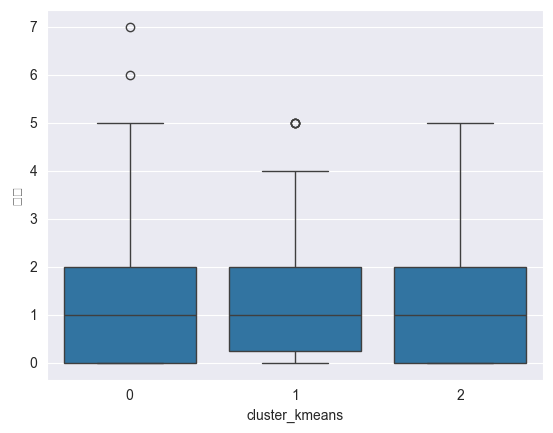

In [80]:
from scipy.stats import f_oneway

# 군집 간 평균 차이 시각화 + ANOVA
sns.boxplot(data=df, x='cluster_kmeans', y='실점')
f_val, p_val = f_oneway(
    df[df['cluster_kmeans']==0]['실점'],
    df[df['cluster_kmeans']==1]['실점'],
    df[df['cluster_kmeans']==2]['실점']
)



In [81]:
def calc_points(row):
    diff = row['득점'] - row['실점']
    if diff > 0:
        return 3
    elif diff == 0:
        return 1
    else:
        return 0




In [82]:
final_df

,감독,cluster,득점,실점,ppm
0,최용수,0,0.600000,1.450000,0.600000
1,최용수,1,0.666667,2.666667,0.000000
2,최용수,2,1.400000,1.114286,1.514286
3,윤정환,0,1.433333,1.533333,1.400000
4,윤정환,1,1.428571,1.428571,1.000000
5,윤정환,2,1.500000,0.888889,1.833333
6,김병수,0,1.235294,1.352941,1.352941
7,김병수,1,0.600000,1.100000,0.700000
8,김병수,2,1.250000,1.875000,1.000000
9,이정효,0,1.363636,1.068182,1.659091


In [83]:
from scipy.stats import f_oneway

# 군집별 PPM 리스트
groups = [df[df['cluster_kmeans'] == k]['승점'] for k in sorted(df['cluster_kmeans'].unique())]

# 일원분산분석
f_stat, p_value = f_oneway(*groups)
print(f"📊 ANOVA F = {f_stat:.3f}, p = {p_value:.5f}")


📊 ANOVA F = 11.452, p = 0.00001


In [84]:
import statsmodels.formula.api as smf

model = smf.ols('승점 ~ C(cluster_kmeans)', data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     승점   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     11.45
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           1.16e-05
Time:                        20:47:26   Log-Likelihood:                -2553.2
No. Observations:                1529   AIC:                             5112.
Df Residuals:                    1526   BIC:                             5128.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [85]:
model_fixed = smf.ols('승점 ~ C(cluster_kmeans) + C(구단)', data=df).fit()
print(model_fixed.summary())

                            OLS Regression Results                            
Dep. Variable:                     승점   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     8.654
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           1.95e-19
Time:                        20:47:26   Log-Likelihood:                -2501.7
No. Observations:                1529   AIC:                             5035.
Df Residuals:                    1513   BIC:                             5121.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_28526/430262846.py:97: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


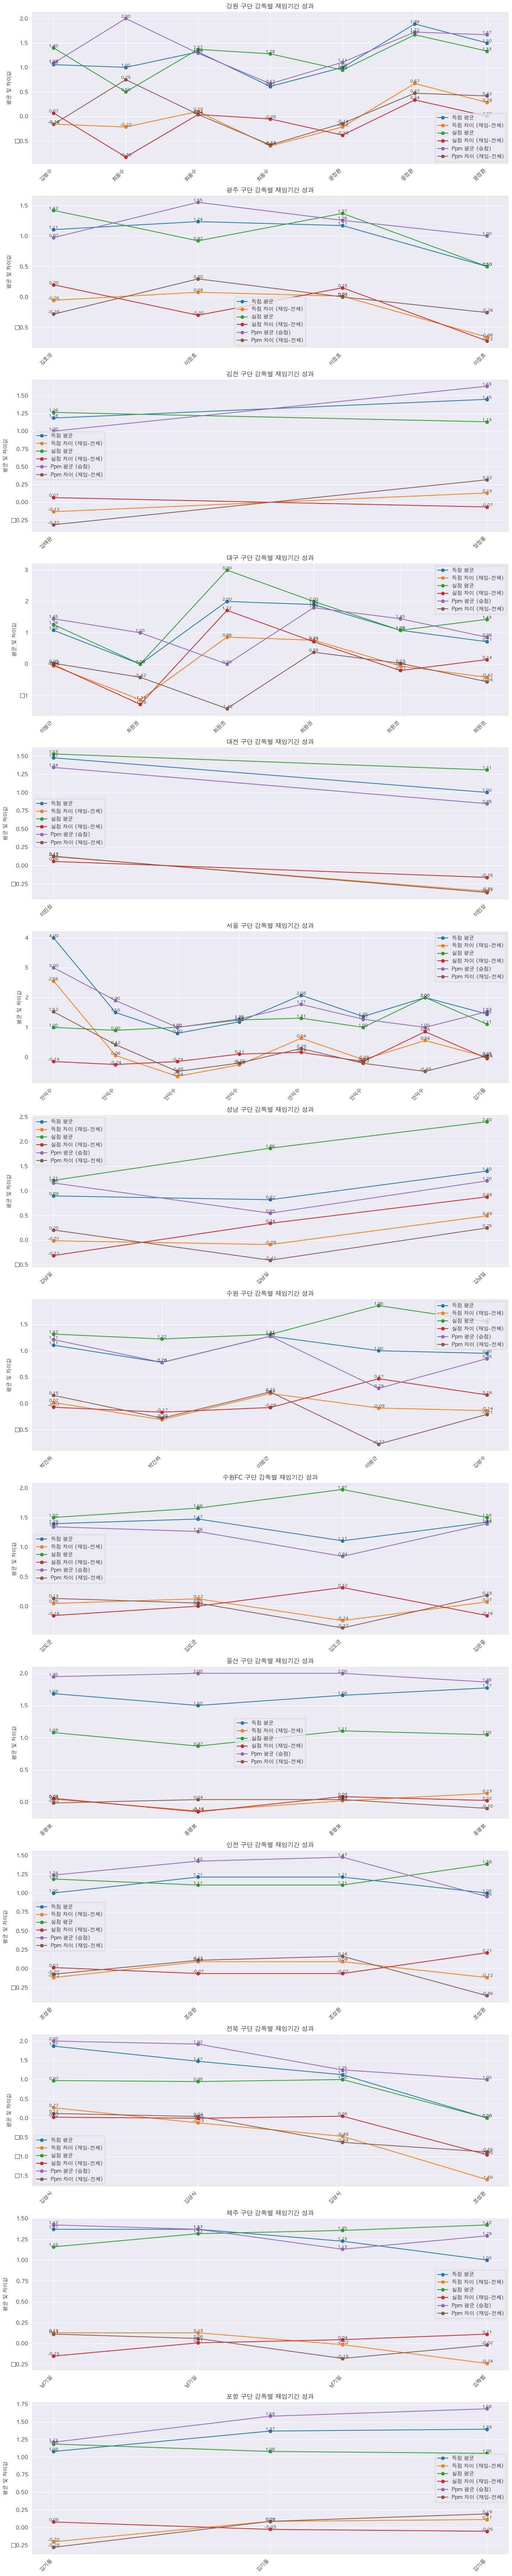

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'
# 1. 년도, 라운드 순 정렬
df = df.sort_values(['년도', '라운드']).reset_index(drop=True)

# 2. 전체기간 구단별 평균 계산 (득점, 실점, 승점 -> Ppm으로 간주)
club_means = df.groupby('구단')[['득점', '실점', '승점']].mean().rename(columns={
    '득점': '득점_전체평균',
    '실점': '실점_전체평균',
    '승점': 'Ppm_전체평균'
})

# 3. 감독-구단별 재임기간 정의
df['년도_라운드_순번'] = df['년도'] * 100 + df['라운드']

df = df.sort_values(['구단', '감독', '년도_라운드_순번']).reset_index(drop=True)

df['재임기간그룹'] = (df.groupby(['구단', '감독'])['년도_라운드_순번']
                      .diff()
                      .gt(1)  # 1보다 크면 연속 아님
                      .cumsum()
                      .fillna(0)
                     ).astype(int)

df['재임기간그룹'] = df.groupby(['구단', '감독'])['재임기간그룹'].transform(lambda x: x - x.min())

# 4. 재임기간별 성과 집계 (승점 → Ppm평균)
period_stats = (df.groupby(['구단', '감독', '재임기간그룹'])
                  .agg(
                      득점평균=('득점', 'mean'),
                      실점평균=('실점', 'mean'),
                      Ppm평균=('승점', 'mean'),
                      시작년도=('년도', 'min'),
                      시작라운드=('라운드', 'min'),
                      끝년도=('년도', 'max'),
                      끝라운드=('라운드', 'max'),
                      count=('년도', 'count')
                  )
                  .reset_index())

# 5. 전체 구단 평균값과 병합 및 차이 컬럼 생성
period_stats = period_stats.merge(club_means, left_on='구단', right_index=True)

period_stats['득점차이'] = period_stats['득점평균'] - period_stats['득점_전체평균']
period_stats['실점차이'] = period_stats['실점평균'] - period_stats['실점_전체평균']
period_stats['Ppm차이'] = period_stats['Ppm평균'] - period_stats['Ppm_전체평균']

# 6. 시계열 정렬용 컬럼 생성
period_stats['재임시작순번'] = period_stats['시작년도'] * 100 + period_stats['시작라운드']
period_stats = period_stats.sort_values(['구단', '재임시작순번'])

# 7. 시각화 (구단별 subplot), x축: 감독명, 포인트 위에 값 표시
clubs = period_stats['구단'].unique()
num_clubs = len(clubs)

fig, axes = plt.subplots(num_clubs, 1, figsize=(14, 5*num_clubs), sharex=False)

if num_clubs == 1:
    axes = [axes]

for ax, club in zip(axes, clubs):
    sub_df = period_stats[period_stats['구단'] == club]

    x = sub_df['감독']
    x_pos = range(len(x))

    # 각 성과 지표 그리기
    ax.plot(x_pos, sub_df['득점평균'], label='득점 평균', marker='o')
    ax.plot(x_pos, sub_df['득점차이'], label='득점 차이 (재임-전체)', marker='o')
    ax.plot(x_pos, sub_df['실점평균'], label='실점 평균', marker='o')
    ax.plot(x_pos, sub_df['실점차이'], label='실점 차이 (재임-전체)', marker='o')
    ax.plot(x_pos, sub_df['Ppm평균'], label='Ppm 평균 (승점)', marker='o')
    ax.plot(x_pos, sub_df['Ppm차이'], label='Ppm 차이 (재임-전체)', marker='o')

    # 각 점 위에 값 표시
    for i, (dp, dd, sp, sd, pp, ppc) in enumerate(zip(
        sub_df['득점평균'], sub_df['득점차이'],
        sub_df['실점평균'], sub_df['실점차이'],
        sub_df['Ppm평균'], sub_df['Ppm차이'])):

        ax.text(i, dp, f'{dp:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i, dd, f'{dd:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i, sp, f'{sp:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i, sd, f'{sd:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i, pp, f'{pp:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i, ppc, f'{ppc:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_title(f"{club} 구단 감독별 재임기간 성과")
    ax.set_ylabel("평균 및 차이값")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
